# Exploratory Data Analysis

In [1]:
# Find JIRA dataset file from local Drive
!dir input

 Volume in drive C is Windows
 Volume Serial Number is 80A8-9307

 Directory of C:\Users\rahul\Desktop\Hackathon 2023\hackathon2023\input

11-07-2023  20:53    <DIR>          .
11-07-2023  20:53    <DIR>          ..
10-07-2023  15:27            46,712 Emp_data.csv
11-07-2023  20:53            54,560 Emp_data_v2.csv
10-07-2023  15:27            14,485 move_in_sync_data.csv
11-07-2023  20:53            14,485 move_in_sync_data_v2.csv
10-07-2023  15:27            27,146 vendor.csv
11-07-2023  20:53            28,883 vendor_v2.csv
               6 File(s)        186,271 bytes
               2 Dir(s)  50,935,590,912 bytes free


In [2]:
# Import labraries
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from prophet import Prophet
import plotly.express as px

%matplotlib inline

import warnings
warnings.simplefilter(action='ignore', category=(FutureWarning))

### Load datasets

In [3]:
employee_df = pd.read_csv('input/Emp_data_v2.csv')
comute_df = pd.read_csv('input/move_in_sync_data_v2.csv')
vendor_df = pd.read_csv('input/vendor_v2.csv')

#### Cleaning and analysing Employee dataaset

In [4]:
#employee_df.head()

In [5]:
employee_df = employee_df.loc[:, ~employee_df.columns.str.contains('^Unnamed')]
employee_df.drop(columns=['day'], inplace=True)

In [6]:
#employee_df.info()

In [7]:
# Convert to pandas datetime format
employee_df['Swipe_In']=pd.to_datetime(employee_df['Swipe_In'],  format='%d-%m-%Y %H:%M')
employee_df['Swipe_Out']=pd.to_datetime(employee_df['Swipe_Out'],  format='%d-%m-%Y %H:%M')

In [8]:
#Distribution of Location 
employee_df['Location'].value_counts()

Location
MGP    359
MUM    339
BB     337
Name: count, dtype: int64

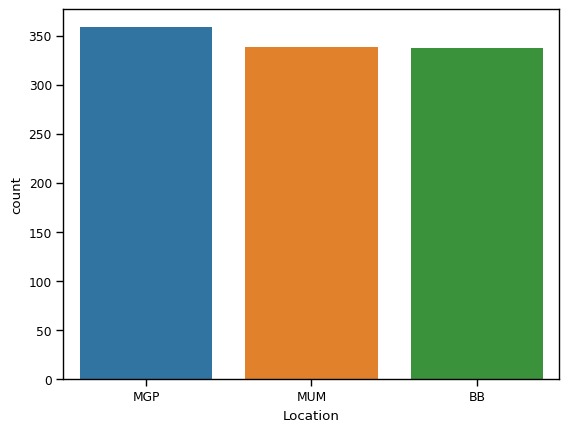

In [9]:
sns.set_context('paper')
sns.barplot(x=employee_df.Location.value_counts().index, y=employee_df.Location.value_counts())
plt.show()

In [10]:
employee_df.head()

EMP_ID Location            Swipe_In           Swipe_Out
0  8626487      MUM 2022-10-04 15:23:00 2022-10-05 01:23:00
1  8631177      MUM 2023-06-08 21:17:00 2023-06-09 07:17:00
2  8678631      MGP 2022-12-23 10:18:00 2022-12-23 19:18:00
3  8574819       BB 2022-08-03 18:26:00 2022-08-04 05:26:00
4  8587539      MGP 2023-01-12 12:57:00 2023-01-12 18:57:00

# Comute dataset

In [11]:
comute_df.head()

EMP_ID Location Car_Park  Commute_to_office_mins  Commute_from_office_mins
0  8626487      MGP       NO                    21.0                      32.0
1  8631177      MUM      YES                     NaN                       NaN
2  8678631       BB       NO                    99.0                     200.0
3  8574819      MUM      YES                     NaN                       NaN
4  8587539       BB      YES                     NaN                       NaN

In [12]:
combine_df = pd.merge(employee_df, comute_df, on=["EMP_ID","Location"], how="left")

In [13]:
combine_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1035 entries, 0 to 1034
Data columns (total 7 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   EMP_ID                    1035 non-null   int64         
 1   Location                  1035 non-null   object        
 2   Swipe_In                  1035 non-null   datetime64[ns]
 3   Swipe_Out                 1035 non-null   datetime64[ns]
 4   Car_Park                  265 non-null    object        
 5   Commute_to_office_mins    134 non-null    float64       
 6   Commute_from_office_mins  134 non-null    float64       
dtypes: datetime64[ns](2), float64(2), int64(1), object(2)
memory usage: 56.7+ KB


In [14]:
combine_df.head()

EMP_ID Location            Swipe_In           Swipe_Out Car_Park  \
0  8626487      MUM 2022-10-04 15:23:00 2022-10-05 01:23:00      NaN   
1  8631177      MUM 2023-06-08 21:17:00 2023-06-09 07:17:00      YES   
2  8678631      MGP 2022-12-23 10:18:00 2022-12-23 19:18:00      NaN   
3  8574819       BB 2022-08-03 18:26:00 2022-08-04 05:26:00      NaN   
4  8587539      MGP 2023-01-12 12:57:00 2023-01-12 18:57:00      NaN   

   Commute_to_office_mins  Commute_from_office_mins  
0                     NaN                       NaN  
1                     NaN                       NaN  
2                     NaN                       NaN  
3                     NaN                       NaN  
4                     NaN                       NaN

In [15]:
# As missing data is > 70% hence dropping NAN columns which having 
combine_df.drop(columns=['Car_Park','Commute_to_office_mins','Commute_from_office_mins'], inplace=True)

In [16]:
# Considering Swipe_in date as working date
combine_df['Working_Date'] = combine_df['Swipe_In'].dt.date
combine_df['dayofweek'] = combine_df['Swipe_In'].dt.dayofweek

In [17]:
combine_df.head()

EMP_ID Location            Swipe_In           Swipe_Out Working_Date  \
0  8626487      MUM 2022-10-04 15:23:00 2022-10-05 01:23:00   2022-10-04   
1  8631177      MUM 2023-06-08 21:17:00 2023-06-09 07:17:00   2023-06-08   
2  8678631      MGP 2022-12-23 10:18:00 2022-12-23 19:18:00   2022-12-23   
3  8574819       BB 2022-08-03 18:26:00 2022-08-04 05:26:00   2022-08-03   
4  8587539      MGP 2023-01-12 12:57:00 2023-01-12 18:57:00   2023-01-12   

   dayofweek  
0          1  
1          3  
2          4  
3          2  
4          3

In [18]:
# map the day of the week number to its name
combine_df['dayofweek'] = combine_df['dayofweek'].map({
    0: 'Monday',
    1: 'Tuesday',
    2: 'Wednesday',
    3: 'Thursday',
    4: 'Friday',
    5: 'Saturday',
    6: 'Sunday'
})

In [19]:
combine_df.head()

EMP_ID Location            Swipe_In           Swipe_Out Working_Date  \
0  8626487      MUM 2022-10-04 15:23:00 2022-10-05 01:23:00   2022-10-04   
1  8631177      MUM 2023-06-08 21:17:00 2023-06-09 07:17:00   2023-06-08   
2  8678631      MGP 2022-12-23 10:18:00 2022-12-23 19:18:00   2022-12-23   
3  8574819       BB 2022-08-03 18:26:00 2022-08-04 05:26:00   2022-08-03   
4  8587539      MGP 2023-01-12 12:57:00 2023-01-12 18:57:00   2023-01-12   

   dayofweek  
0    Tuesday  
1   Thursday  
2     Friday  
3  Wednesday  
4   Thursday

In [160]:
# Drop employee ID which is qunique in nature
combine_df.drop(columns=['EMP_ID'], inplace=True)

In [20]:
combine_df.head()

EMP_ID Location            Swipe_In           Swipe_Out Working_Date  \
0  8626487      MUM 2022-10-04 15:23:00 2022-10-05 01:23:00   2022-10-04   
1  8631177      MUM 2023-06-08 21:17:00 2023-06-09 07:17:00   2023-06-08   
2  8678631      MGP 2022-12-23 10:18:00 2022-12-23 19:18:00   2022-12-23   
3  8574819       BB 2022-08-03 18:26:00 2022-08-04 05:26:00   2022-08-03   
4  8587539      MGP 2023-01-12 12:57:00 2023-01-12 18:57:00   2023-01-12   

   dayofweek  
0    Tuesday  
1   Thursday  
2     Friday  
3  Wednesday  
4   Thursday

In [30]:
num_of_emp_df = combine_df['EMP_ID'].groupby([combine_df.Working_Date]).agg('count')

<Axes: xlabel='Working_Date'>

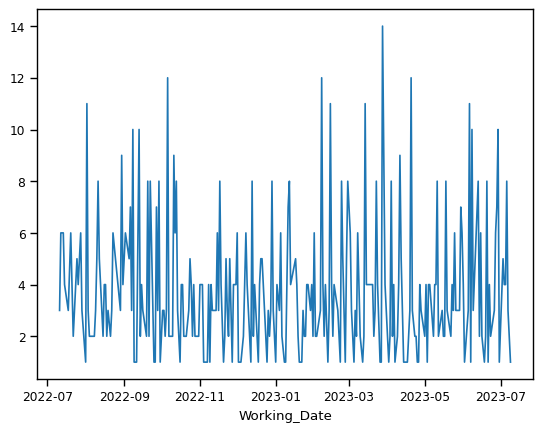

In [42]:
num_of_emp_df.plot()

# Vendor dataset Cleaning

In [32]:
vendor_df.head()

Vendor              Date  Transaction_Value  Unnamed: 3  day
0  ANTARANG  01-09-2022 07:56                289         NaN  Thu
1     SWARA  07-02-2023 04:07                440         NaN  Tue
2    SUBWAY  09-03-2023 07:48                155         NaN  Thu
3     SWARA  29-05-2023 02:57                312         NaN  Mon
4   VOHUMAN  13-03-2023 14:18                459         NaN  Mon

In [33]:
vendor_df = vendor_df.loc[:, ~vendor_df.columns.str.contains('^Unnamed')]
vendor_df.drop(columns=['day'], inplace=True)

C:\Users\rahul\AppData\Local\Temp\ipykernel_11460\4100408089.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vendor_df.drop(columns=['day'], inplace=True)


In [34]:
# Convert to pandas datetime format
vendor_df['Date']=pd.to_datetime(vendor_df['Date'],  format='%d-%m-%Y %H:%M')
vendor_df['Transaction_Date'] = vendor_df['Date'].dt.date
vendor_df['dayofweek'] = vendor_df['Date'].dt.dayofweek

C:\Users\rahul\AppData\Local\Temp\ipykernel_11460\2622144458.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vendor_df['Date']=pd.to_datetime(vendor_df['Date'],  format='%d-%m-%Y %H:%M')
C:\Users\rahul\AppData\Local\Temp\ipykernel_11460\2622144458.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vendor_df['Transaction_Date'] = vendor_df['Date'].dt.date


In [35]:
vendor_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 808 entries, 0 to 807
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Vendor             808 non-null    object        
 1   Date               808 non-null    datetime64[ns]
 2   Transaction_Value  808 non-null    int64         
 3   Transaction_Date   808 non-null    object        
 4   dayofweek          808 non-null    int32         
dtypes: datetime64[ns](1), int32(1), int64(1), object(2)
memory usage: 28.5+ KB


In [36]:
# map the day of the week number to its name
vendor_df['dayofweek'] = vendor_df['dayofweek'].map({
    0: 'Monday',
    1: 'Tuesday',
    2: 'Wednesday',
    3: 'Thursday',
    4: 'Friday',
    5: 'Saturday',
    6: 'Sunday'
})

In [37]:
vendor_df.head()

Vendor                Date  Transaction_Value Transaction_Date dayofweek
0  ANTARANG 2022-09-01 07:56:00                289       2022-09-01  Thursday
1     SWARA 2023-02-07 04:07:00                440       2023-02-07   Tuesday
2    SUBWAY 2023-03-09 07:48:00                155       2023-03-09  Thursday
3     SWARA 2023-05-29 02:57:00                312       2023-05-29    Monday
4   VOHUMAN 2023-03-13 14:18:00                459       2023-03-13    Monday

In [39]:
num_of_trans_df = vendor_df['Transaction_Value'].groupby([vendor_df.Transaction_Date]).agg('count')

<Axes: xlabel='Transaction_Date'>

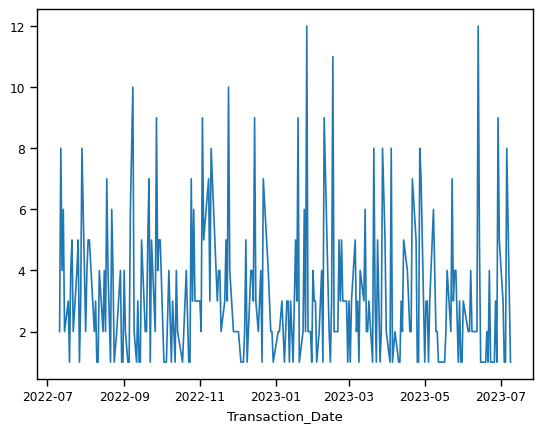

In [43]:
num_of_trans_df.plot()

In [ ]:
# Combine data for Employee visitng office and vendor transaction 

In [45]:
num_of_emp_df.info()

<class 'pandas.core.series.Series'>
Index: 269 entries, 2022-07-11 to 2023-07-09
Series name: EMP_ID
Non-Null Count  Dtype
--------------  -----
269 non-null    int64
dtypes: int64(1)
memory usage: 4.2+ KB


In [44]:
num_of_trans_df.info()

<class 'pandas.core.series.Series'>
Index: 250 entries, 2022-07-11 to 2023-07-09
Series name: Transaction_Value
Non-Null Count  Dtype
--------------  -----
250 non-null    int64
dtypes: int64(1)
memory usage: 3.9+ KB


In [47]:
display_df = pd.concat([num_of_emp_df,num_of_trans_df],axis=1)

In [49]:
display_df.head()

EMP_ID  Transaction_Value
2022-07-11     3.0                2.0
2022-07-12     6.0                8.0
2022-07-13     6.0                4.0
2022-07-14     6.0                6.0
2022-07-15     4.0                2.0

<Axes: >

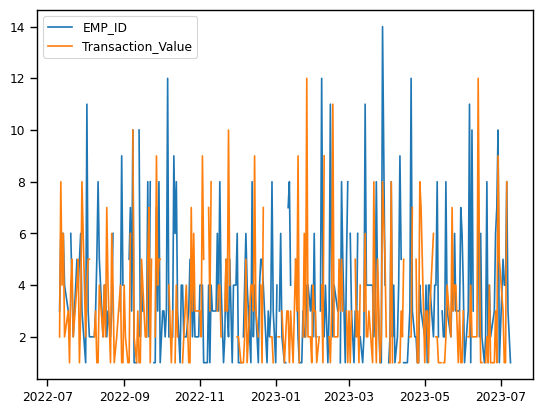

In [48]:
display_df.plot()

<Axes: xlabel='EMP_ID', ylabel='count'>

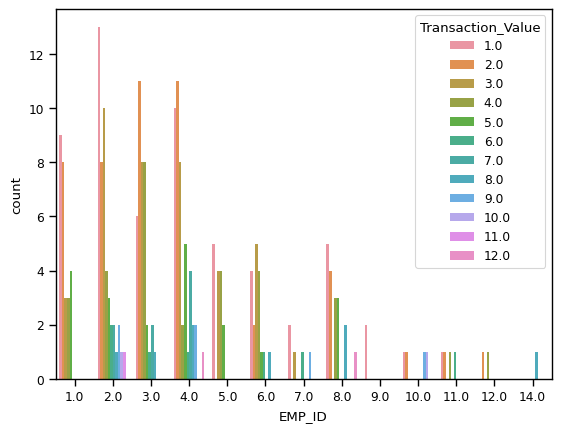

In [50]:
# count plot on two categorical variable
sns.countplot(x ='EMP_ID', hue = "Transaction_Value", data = display_df)

# Analysis with combine database 

In [167]:
combine_df.head()

Location            Swipe_In           Swipe_Out Working_Date  dayofweek
0      MUM 2022-10-04 15:23:00 2022-10-05 01:23:00   2022-10-04    Tuesday
1      MUM 2023-06-08 21:17:00 2023-06-09 07:17:00   2023-06-08   Thursday
2      MGP 2022-12-23 10:18:00 2022-12-23 19:18:00   2022-12-23     Friday
3       BB 2022-08-03 18:26:00 2022-08-04 05:26:00   2022-08-03  Wednesday
4      MGP 2023-01-12 12:57:00 2023-01-12 18:57:00   2023-01-12   Thursday

<Axes: >

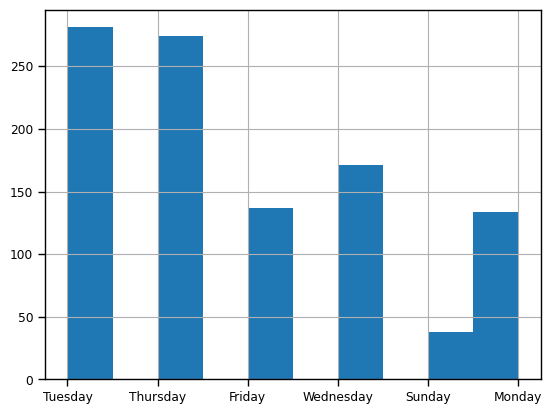

In [168]:
# Draw a histogram of a column (the distribution of dayofweek).
combine_df.dayofweek.hist()

In [169]:
combine_df.dayofweek.value_counts()  

dayofweek
Tuesday      281
Thursday     274
Wednesday    171
Friday       137
Monday       134
Sunday        38
Name: count, dtype: int64

<Axes: >

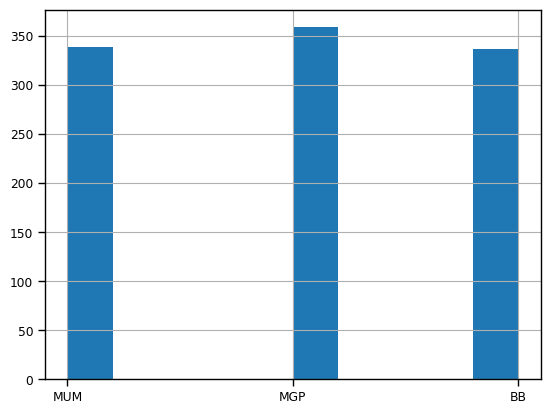

In [170]:
# Draw a histogram of a column (the distribution of dayofweek).
combine_df.Location.hist()

In [171]:
combine_df.Location.value_counts()  

Location
MGP    359
MUM    339
BB     337
Name: count, dtype: int64

In [172]:
#combine_df = combine_df.set_index('Working_Date')

In [173]:
combine_df['Year'] = combine_df.Swipe_In.dt.year
combine_df['Month'] = combine_df.Swipe_In.dt.month

In [174]:
combine_df.head()

Location            Swipe_In           Swipe_Out Working_Date  dayofweek  \
0      MUM 2022-10-04 15:23:00 2022-10-05 01:23:00   2022-10-04    Tuesday   
1      MUM 2023-06-08 21:17:00 2023-06-09 07:17:00   2023-06-08   Thursday   
2      MGP 2022-12-23 10:18:00 2022-12-23 19:18:00   2022-12-23     Friday   
3       BB 2022-08-03 18:26:00 2022-08-04 05:26:00   2022-08-03  Wednesday   
4      MGP 2023-01-12 12:57:00 2023-01-12 18:57:00   2023-01-12   Thursday   

   Year  Month  
0  2022     10  
1  2023      6  
2  2022     12  
3  2022      8  
4  2023      1

In [175]:
combine_df[combine_df.Year == 2022]

Location            Swipe_In           Swipe_Out Working_Date  dayofweek  \
0         MUM 2022-10-04 15:23:00 2022-10-05 01:23:00   2022-10-04    Tuesday   
2         MGP 2022-12-23 10:18:00 2022-12-23 19:18:00   2022-12-23     Friday   
3          BB 2022-08-03 18:26:00 2022-08-04 05:26:00   2022-08-03  Wednesday   
7         MUM 2022-09-13 23:39:00 2022-09-14 11:39:00   2022-09-13    Tuesday   
13         BB 2022-12-13 07:45:00 2022-12-13 15:45:00   2022-12-13    Tuesday   
...       ...                 ...                 ...          ...        ...   
1014      MGP 2022-07-21 06:12:00 2022-07-21 17:12:00   2022-07-21   Thursday   
1022      MGP 2022-09-29 19:13:00 2022-09-30 01:13:00   2022-09-29   Thursday   
1023       BB 2022-12-08 22:09:00 2022-12-09 06:09:00   2022-12-08   Thursday   
1024      MUM 2022-12-08 05:21:00 2022-12-08 11:21:00   2022-12-08   Thursday   
1031       BB 2022-09-08 00:45:00 2022-09-08 09:45:00   2022-09-08   Thursday   

      Year  Month  
0     2022     10  
2     2022     12  
3     2022      8  
7     2022      9  
13    2022     12  
...    ...    ...  
1014  2022      7  
1022  2022      9  
1023  2022     12  
1024  2022     12  
1031  2022      9  

[495 rows x 7 columns]

In [43]:
#final_df.index =  pd.to_datetime(final_df.index)

<Axes: >

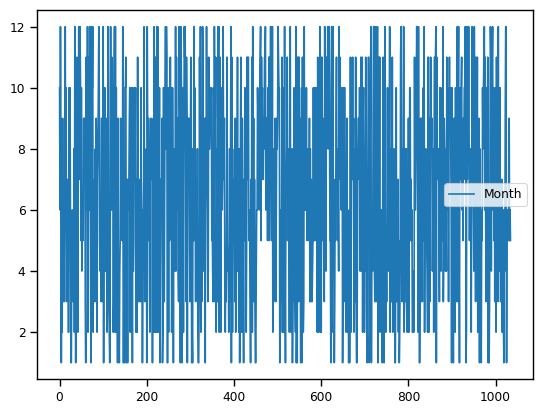

In [67]:
combine_df[['Month']].plot()

In [100]:
vendor_df= vendor_df.set_index('Transaction_Date')
combine_df= combine_df.set_index('Working_Date')

In [103]:
dataframe_common = pd.merge(combine_df, vendor_df, left_index=True, right_index=True)

In [104]:
dataframe_common.head()

Location            Swipe_In           Swipe_Out dayofweek_x  \
Working_Date                                                                
2022-07-11        MGP 2022-07-11 02:38:00 2022-07-11 14:38:00      Monday   
2022-07-11        MGP 2022-07-11 02:38:00 2022-07-11 14:38:00      Monday   
2022-07-11         BB 2022-07-11 21:18:00 2022-07-12 07:18:00      Monday   
2022-07-11         BB 2022-07-11 21:18:00 2022-07-12 07:18:00      Monday   
2022-07-11         BB 2022-07-11 21:38:00 2022-07-12 04:38:00      Monday   

              Year  Month    Vendor                Date  Transaction_Value  \
Working_Date                                                                 
2022-07-11    2022      7    BISTRO 2022-07-11 21:38:00                467   
2022-07-11    2022      7  ANTARANG 2022-07-11 04:17:00                225   
2022-07-11    2022      7    BISTRO 2022-07-11 21:38:00                467   
2022-07-11    2022      7  ANTARANG 2022-07-11 04:17:00                225   
2022-07-11    2022      7    BISTRO 2022-07-11 21:38:00                467   

             dayofweek_y  
Working_Date              
2022-07-11        Monday  
2022-07-11        Monday  
2022-07-11        Monday  
2022-07-11        Monday  
2022-07-11        Monday

In [106]:
dataframe = pd.concat([combine_df, vendor_df])

In [107]:
dataframe.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1843 entries, 2022-10-04 to 2022-11-24
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Location           1035 non-null   object        
 1   Swipe_In           1035 non-null   datetime64[ns]
 2   Swipe_Out          1035 non-null   datetime64[ns]
 3   dayofweek          1843 non-null   object        
 4   Year               1035 non-null   float64       
 5   Month              1035 non-null   float64       
 6   Vendor             808 non-null    object        
 7   Date               808 non-null    datetime64[ns]
 8   Transaction_Value  808 non-null    float64       
dtypes: datetime64[ns](3), float64(3), object(3)
memory usage: 144.0+ KB


In [109]:
dataframe

Location            Swipe_In           Swipe_Out  dayofweek  \
2022-10-04      MUM 2022-10-04 15:23:00 2022-10-05 01:23:00    Tuesday   
2023-06-08      MUM 2023-06-08 21:17:00 2023-06-09 07:17:00   Thursday   
2022-12-23      MGP 2022-12-23 10:18:00 2022-12-23 19:18:00     Friday   
2022-08-03       BB 2022-08-03 18:26:00 2022-08-04 05:26:00  Wednesday   
2023-01-12      MGP 2023-01-12 12:57:00 2023-01-12 18:57:00   Thursday   
...             ...                 ...                 ...        ...   
2022-11-24      NaN                 NaT                 NaT   Thursday   
2022-11-17      NaN                 NaT                 NaT   Thursday   
2022-09-29      NaN                 NaT                 NaT   Thursday   
2022-08-02      NaN                 NaT                 NaT    Tuesday   
2022-11-24      NaN                 NaT                 NaT   Thursday   

              Year  Month            Vendor                Date  \
2022-10-04  2022.0   10.0               NaN                 NaT   
2023-06-08  2023.0    6.0               NaN                 NaT   
2022-12-23  2022.0   12.0               NaN                 NaT   
2022-08-03  2022.0    8.0               NaN                 NaT   
2023-01-12  2023.0    1.0               NaN                 NaT   
...            ...    ...               ...                 ...   
2022-11-24     NaN    NaN          ANTARANG 2022-11-24 06:12:00   
2022-11-17     NaN    NaN  SOUTHERN EXPRESS 2022-11-17 05:41:00   
2022-09-29     NaN    NaN             SWARA 2022-09-29 08:03:00   
2022-08-02     NaN    NaN  SOUTHERN EXPRESS 2022-08-02 03:51:00   
2022-11-24     NaN    NaN  SOUTHERN EXPRESS 2022-11-24 04:56:00   

            Transaction_Value  
2022-10-04                NaN  
2023-06-08                NaN  
2022-12-23                NaN  
2022-08-03                NaN  
2023-01-12                NaN  
...                       ...  
2022-11-24              469.0  
2022-11-17              462.0  
2022-09-29              171.0  
2022-08-02              419.0  
2022-11-24              199.0  

[1843 rows x 9 columns]

In [ ]:
# Drop more than 50 % Null values columns
#dataframe.drop(columns=['dayofweek_y'], inplace=True)

In [111]:
dataframe.head()

Location            Swipe_In           Swipe_Out  dayofweek  \
2022-10-04      MUM 2022-10-04 15:23:00 2022-10-05 01:23:00    Tuesday   
2023-06-08      MUM 2023-06-08 21:17:00 2023-06-09 07:17:00   Thursday   
2022-12-23      MGP 2022-12-23 10:18:00 2022-12-23 19:18:00     Friday   
2022-08-03       BB 2022-08-03 18:26:00 2022-08-04 05:26:00  Wednesday   
2023-01-12      MGP 2023-01-12 12:57:00 2023-01-12 18:57:00   Thursday   

              Year  Month Vendor Date  Transaction_Value  
2022-10-04  2022.0   10.0    NaN  NaT                NaN  
2023-06-08  2023.0    6.0    NaN  NaT                NaN  
2022-12-23  2022.0   12.0    NaN  NaT                NaN  
2022-08-03  2022.0    8.0    NaN  NaT                NaN  
2023-01-12  2023.0    1.0    NaN  NaT                NaN

In [89]:
# Slicing for common working and transaction date
# dataframe.loc[(dataframe.Working_Date == dataframe.Transaction_Date )]

In [112]:
 dataframe.loc[(dataframe.Year == 2022 )]

Location            Swipe_In           Swipe_Out  dayofweek  \
2022-10-04      MUM 2022-10-04 15:23:00 2022-10-05 01:23:00    Tuesday   
2022-12-23      MGP 2022-12-23 10:18:00 2022-12-23 19:18:00     Friday   
2022-08-03       BB 2022-08-03 18:26:00 2022-08-04 05:26:00  Wednesday   
2022-09-13      MUM 2022-09-13 23:39:00 2022-09-14 11:39:00    Tuesday   
2022-12-13       BB 2022-12-13 07:45:00 2022-12-13 15:45:00    Tuesday   
...             ...                 ...                 ...        ...   
2022-07-21      MGP 2022-07-21 06:12:00 2022-07-21 17:12:00   Thursday   
2022-09-29      MGP 2022-09-29 19:13:00 2022-09-30 01:13:00   Thursday   
2022-12-08       BB 2022-12-08 22:09:00 2022-12-09 06:09:00   Thursday   
2022-12-08      MUM 2022-12-08 05:21:00 2022-12-08 11:21:00   Thursday   
2022-09-08       BB 2022-09-08 00:45:00 2022-09-08 09:45:00   Thursday   

              Year  Month Vendor Date  Transaction_Value  
2022-10-04  2022.0   10.0    NaN  NaT                NaN  
2022-12-23  2022.0   12.0    NaN  NaT                NaN  
2022-08-03  2022.0    8.0    NaN  NaT                NaN  
2022-09-13  2022.0    9.0    NaN  NaT                NaN  
2022-12-13  2022.0   12.0    NaN  NaT                NaN  
...            ...    ...    ...  ...                ...  
2022-07-21  2022.0    7.0    NaN  NaT                NaN  
2022-09-29  2022.0    9.0    NaN  NaT                NaN  
2022-12-08  2022.0   12.0    NaN  NaT                NaN  
2022-12-08  2022.0   12.0    NaN  NaT                NaN  
2022-09-08  2022.0    9.0    NaN  NaT                NaN  

[495 rows x 9 columns]

In [91]:
#dataframe.Vendor.unique().tolist()

In [57]:
#dataframe.index.value_counts().values.tolist()

In [92]:
#dataframe.Vendor.value_counts()
# dataframe.groupby('Vendor').Vendor.count()

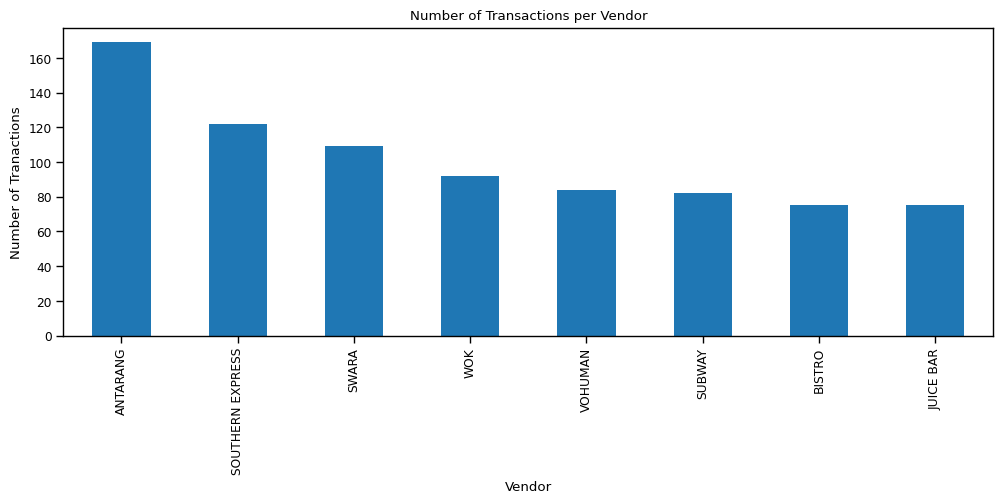

In [113]:
dataframe.Vendor.value_counts().plot(kind='bar',figsize=(12,4)) 
plt.xlabel('Vendor');
plt.ylabel('Number of Tranactions');
plt.title('Number of Transactions per Vendor');

In [121]:
dataframe.reset_index(level=0, inplace=True)

In [122]:
dataframe.groupby('Vendor').Transaction_Value.mean()

Vendor
ANTARANG            261.745562
BISTRO              285.413333
JUICE BAR           246.373333
SOUTHERN EXPRESS    281.106557
SUBWAY              254.073171
SWARA               277.412844
VOHUMAN             264.630952
WOK                 250.358696
Name: Transaction_Value, dtype: float64

<Axes: >

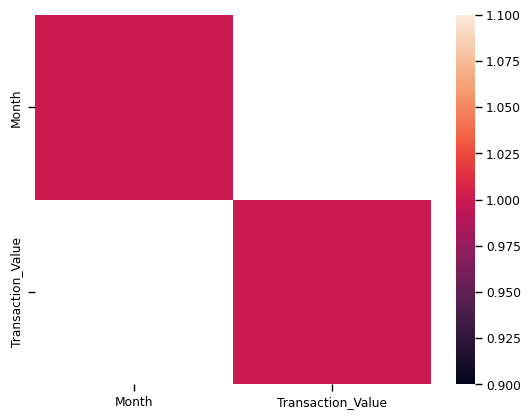

In [123]:
sns.heatmap(dataframe[['Month','Transaction_Value']].corr())

C:\Users\rahul\anaconda3\envs\hackathon\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


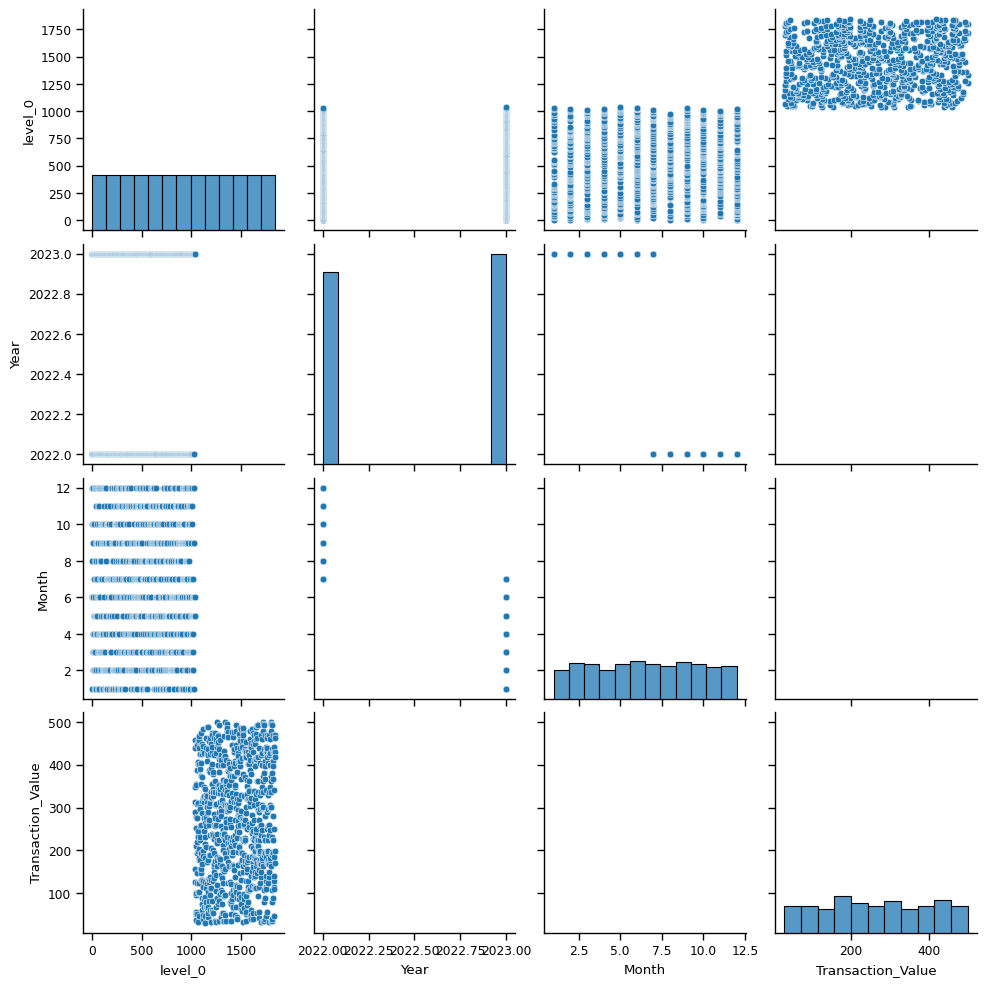

In [126]:
sns.pairplot(dataframe)

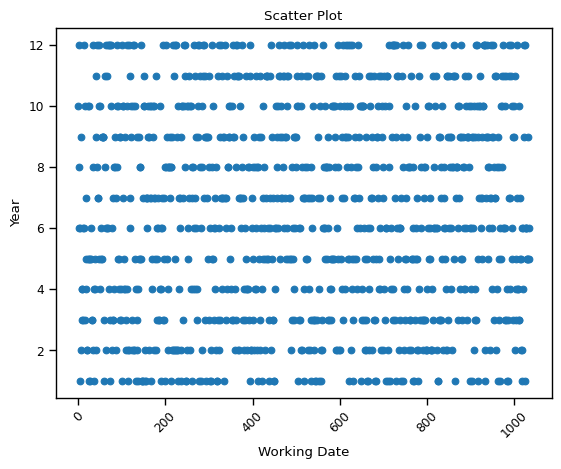

In [129]:
plt.scatter(dataframe.index, dataframe['Month'])

# Set labels and title
plt.xlabel('Working Date')
plt.ylabel('Year')
plt.title('Scatter Plot')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Show the plot
plt.show()

In [128]:
dataframe.head()

level_0       index Location            Swipe_In           Swipe_Out  \
0        0  2022-10-04      MUM 2022-10-04 15:23:00 2022-10-05 01:23:00   
1        1  2023-06-08      MUM 2023-06-08 21:17:00 2023-06-09 07:17:00   
2        2  2022-12-23      MGP 2022-12-23 10:18:00 2022-12-23 19:18:00   
3        3  2022-08-03       BB 2022-08-03 18:26:00 2022-08-04 05:26:00   
4        4  2023-01-12      MGP 2023-01-12 12:57:00 2023-01-12 18:57:00   

   dayofweek    Year  Month Vendor Date  Transaction_Value  
0    Tuesday  2022.0   10.0    NaN  NaT                NaN  
1   Thursday  2023.0    6.0    NaN  NaT                NaN  
2     Friday  2022.0   12.0    NaN  NaT                NaN  
3  Wednesday  2022.0    8.0    NaN  NaT                NaN  
4   Thursday  2023.0    1.0    NaN  NaT                NaN

In [130]:
dataframe.rename(columns={'index':'Working_Date'}, inplace=True)

In [131]:
raw_df = dataframe[['Working_Date','Transaction_Value','Vendor','dayofweek','Month','Year','Location']]

In [132]:
raw_df['Working_Date'] = pd.to_datetime(raw_df['Working_Date'])

C:\Users\rahul\AppData\Local\Temp\ipykernel_5012\2862114500.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  raw_df['Working_Date'] = pd.to_datetime(raw_df['Working_Date'])


In [133]:
raw_df.head()

Working_Date  Transaction_Value Vendor  dayofweek  Month    Year Location
0   2022-10-04                NaN    NaN    Tuesday   10.0  2022.0      MUM
1   2023-06-08                NaN    NaN   Thursday    6.0  2023.0      MUM
2   2022-12-23                NaN    NaN     Friday   12.0  2022.0      MGP
3   2022-08-03                NaN    NaN  Wednesday    8.0  2022.0       BB
4   2023-01-12                NaN    NaN   Thursday    1.0  2023.0      MGP

In [141]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1843 entries, 0 to 1842
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Working_Date       1843 non-null   datetime64[ns]
 1   Transaction_Value  808 non-null    float64       
 2   Vendor             808 non-null    object        
 3   dayofweek          1843 non-null   object        
 4   Month              1035 non-null   float64       
 5   Year               1035 non-null   float64       
 6   Location           1035 non-null   object        
dtypes: datetime64[ns](1), float64(3), object(3)
memory usage: 100.9+ KB


In [134]:
raw_df[(raw_df.Vendor == "ANTARANG") ]

Working_Date  Transaction_Value    Vendor  dayofweek  Month  Year  \
1035   2022-09-01              289.0  ANTARANG   Thursday    NaN   NaN   
1041   2023-05-24              126.0  ANTARANG  Wednesday    NaN   NaN   
1046   2022-08-16               55.0  ANTARANG    Tuesday    NaN   NaN   
1049   2023-05-19               50.0  ANTARANG     Friday    NaN   NaN   
1061   2023-06-13              123.0  ANTARANG    Tuesday    NaN   NaN   
...           ...                ...       ...        ...    ...   ...   
1825   2023-01-26              223.0  ANTARANG   Thursday    NaN   NaN   
1831   2023-05-23              342.0  ANTARANG    Tuesday    NaN   NaN   
1832   2022-09-20               45.0  ANTARANG    Tuesday    NaN   NaN   
1835   2022-08-23              441.0  ANTARANG    Tuesday    NaN   NaN   
1838   2022-11-24              469.0  ANTARANG   Thursday    NaN   NaN   

     Location  
1035      NaN  
1041      NaN  
1046      NaN  
1049      NaN  
1061      NaN  
...       ...  
1825      NaN  
1831      NaN  
1832      NaN  
1835      NaN  
1838      NaN  

[169 rows x 7 columns]

In [135]:
raw_df[(raw_df.Vendor == "ANTARANG") & (raw_df.Year == 2022) ]

Empty DataFrame
Columns: [Working_Date, Transaction_Value, Vendor, dayofweek, Month, Year, Location]
Index: []

In [136]:
raw_df.set_index('Working_Date')

Transaction_Value            Vendor  dayofweek  Month    Year  \
Working_Date                                                                  
2022-10-04                  NaN               NaN    Tuesday   10.0  2022.0   
2023-06-08                  NaN               NaN   Thursday    6.0  2023.0   
2022-12-23                  NaN               NaN     Friday   12.0  2022.0   
2022-08-03                  NaN               NaN  Wednesday    8.0  2022.0   
2023-01-12                  NaN               NaN   Thursday    1.0  2023.0   
...                         ...               ...        ...    ...     ...   
2022-11-24                469.0          ANTARANG   Thursday    NaN     NaN   
2022-11-17                462.0  SOUTHERN EXPRESS   Thursday    NaN     NaN   
2022-09-29                171.0             SWARA   Thursday    NaN     NaN   
2022-08-02                419.0  SOUTHERN EXPRESS    Tuesday    NaN     NaN   
2022-11-24                199.0  SOUTHERN EXPRESS   Thursday    NaN     NaN   

             Location  
Working_Date           
2022-10-04        MUM  
2023-06-08        MUM  
2022-12-23        MGP  
2022-08-03         BB  
2023-01-12        MGP  
...               ...  
2022-11-24        NaN  
2022-11-17        NaN  
2022-09-29        NaN  
2022-08-02        NaN  
2022-11-24        NaN  

[1843 rows x 6 columns]

In [137]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1843 entries, 0 to 1842
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Working_Date       1843 non-null   datetime64[ns]
 1   Transaction_Value  808 non-null    float64       
 2   Vendor             808 non-null    object        
 3   dayofweek          1843 non-null   object        
 4   Month              1035 non-null   float64       
 5   Year               1035 non-null   float64       
 6   Location           1035 non-null   object        
dtypes: datetime64[ns](1), float64(3), object(3)
memory usage: 100.9+ KB


ValueError: zero-size array to reduction operation fmin which has no identity

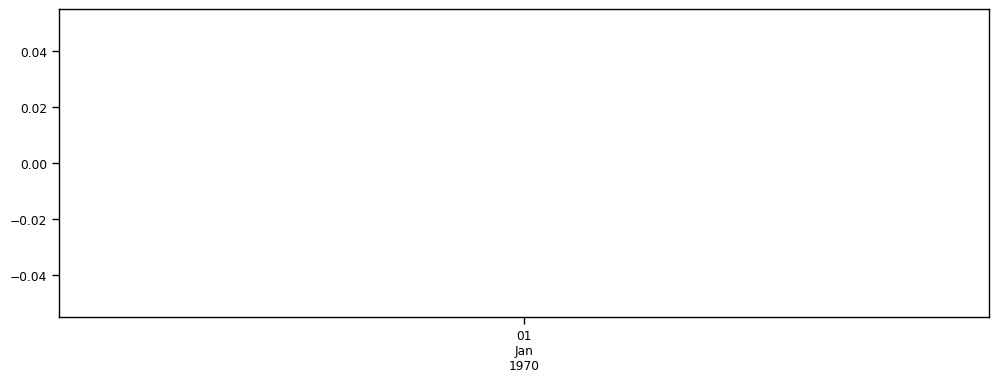

In [138]:
raw_df[(raw_df.Vendor == "ANTARANG") & (raw_df.Month == 1) ].set_index('Working_Date').resample('D').sum().plot(kind='line',figsize=(12,4))

In [74]:
raw_df.head()

Working_Date  Transaction_Value    Vendor dayofweek_x  Month  Year Location
0   2022-10-04                289  ANTARANG     Tuesday     10  2022      MUM
1   2023-06-08                440     SWARA    Thursday      6  2023      MUM
2   2022-12-23                155    SUBWAY      Friday     12  2022      MGP
3   2022-08-03                312     SWARA   Wednesday      8  2022       BB
4   2023-01-12                459   VOHUMAN    Thursday      1  2023      MGP

<Axes: xlabel='Working_Date'>

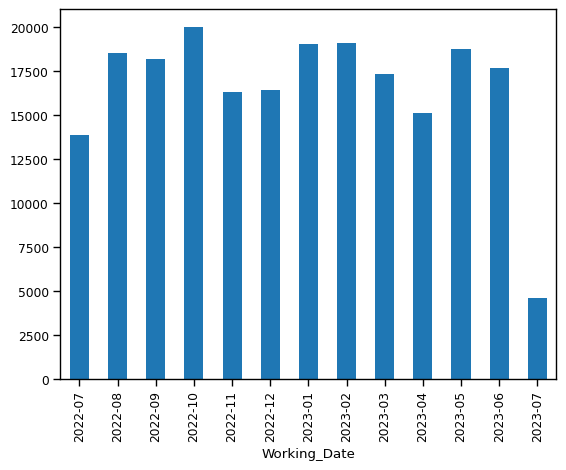

In [75]:
raw_df['Transaction_Value'].groupby(raw_df['Working_Date'].dt.to_period('M')).sum().plot(kind='bar')

In [76]:
df = dataframe['Transaction_Value'].groupby(dataframe['Date'].dt.to_period('D')).sum().to_frame()

In [77]:
#dataframe['Transaction_Value'].groupby(dataframe['Date']).sum().to_frame()

In [78]:
df.Working_Date = df.to_timestamp()

C:\Users\rahul\AppData\Local\Temp\ipykernel_10736\295913564.py:1: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df.Working_Date = df.to_timestamp()


In [79]:
df.reset_index(level=0, inplace=True)

In [80]:
df.rename(columns={'Date':'ds','Transaction_Value':'y'}, inplace=True)

In [81]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250 entries, 0 to 249
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype    
---  ------  --------------  -----    
 0   ds      250 non-null    period[D]
 1   y       250 non-null    int64    
dtypes: int64(1), period[D](1)
memory usage: 4.0 KB


In [82]:
df['ds'] = df['ds'].dt.to_timestamp('s').dt.strftime('%Y-%m-%d %H:%M:%S.000')

In [83]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250 entries, 0 to 249
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   ds      250 non-null    object
 1   y       250 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 4.0+ KB


In [84]:
df.head()

ds     y
0  2022-07-11 00:00:00.000   692
1  2022-07-12 00:00:00.000  1746
2  2022-07-13 00:00:00.000  1134
3  2022-07-14 00:00:00.000  2154
4  2022-07-15 00:00:00.000   630

In [85]:
model = Prophet()
model.fit(df)

08:54:30 - cmdstanpy - INFO - Chain [1] start processing
08:54:31 - cmdstanpy - INFO - Chain [1] done processing


In [86]:
future_dates = model.make_future_dataframe(periods=30)

In [87]:
forecast = model.predict(future_dates)

In [88]:
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()


ds        yhat  yhat_lower   yhat_upper
275 2023-08-04  675.213107 -137.368529  1453.153970
276 2023-08-05  557.638075 -202.376342  1345.571310
277 2023-08-06  143.390837 -663.881839   916.919670
278 2023-08-07  553.729222 -318.677104  1366.797743
279 2023-08-08  881.143251    0.714329  1662.318699

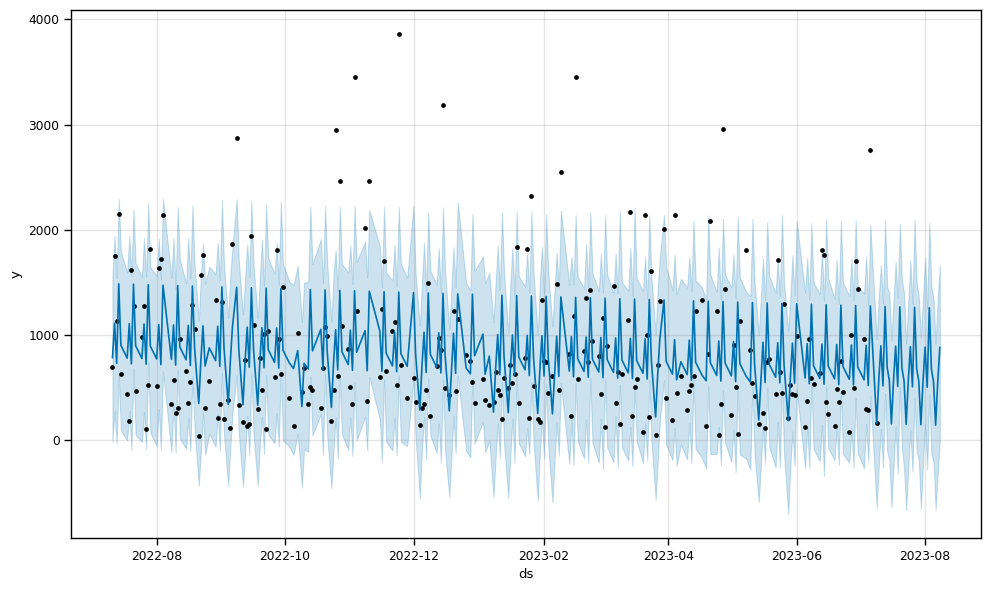

In [89]:
fig1 = model.plot(forecast)


In [90]:
# Prediction for 365 days 
future = model.make_future_dataframe(periods=365)
future.tail()

ds
610 2024-07-04
611 2024-07-05
612 2024-07-06
613 2024-07-07
614 2024-07-08

In [91]:
forecast = model.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

ds         yhat  yhat_lower   yhat_upper
610 2024-07-04  1061.079392  254.473895  1842.424497
611 2024-07-05   477.249476 -347.674026  1302.866604
612 2024-07-06   359.674444 -485.855069  1183.083410
613 2024-07-07   -54.572794 -919.251359   802.869958
614 2024-07-08   355.765591 -415.180345  1158.630245

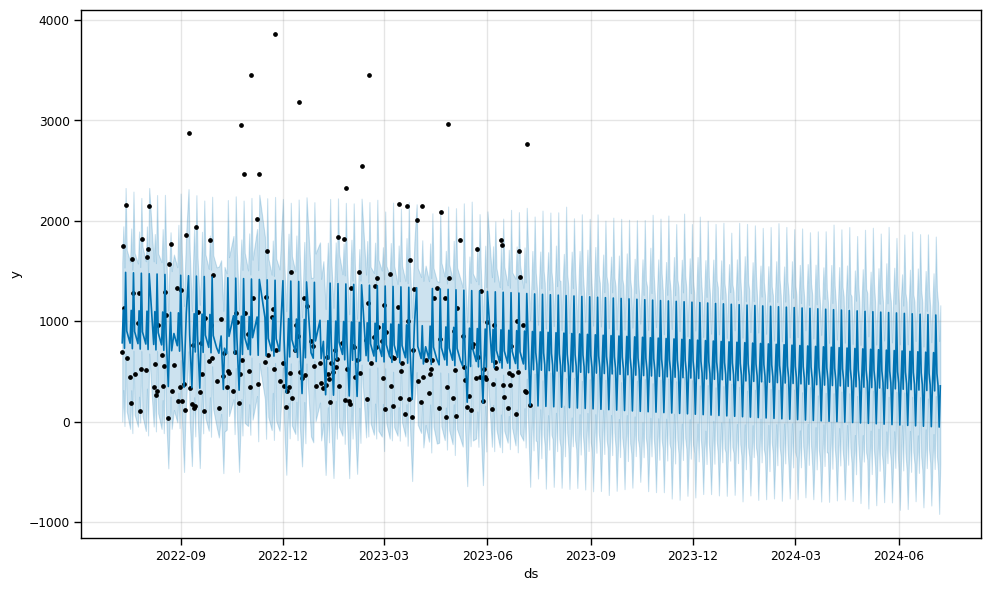

In [92]:
fig1 = model.plot(forecast)


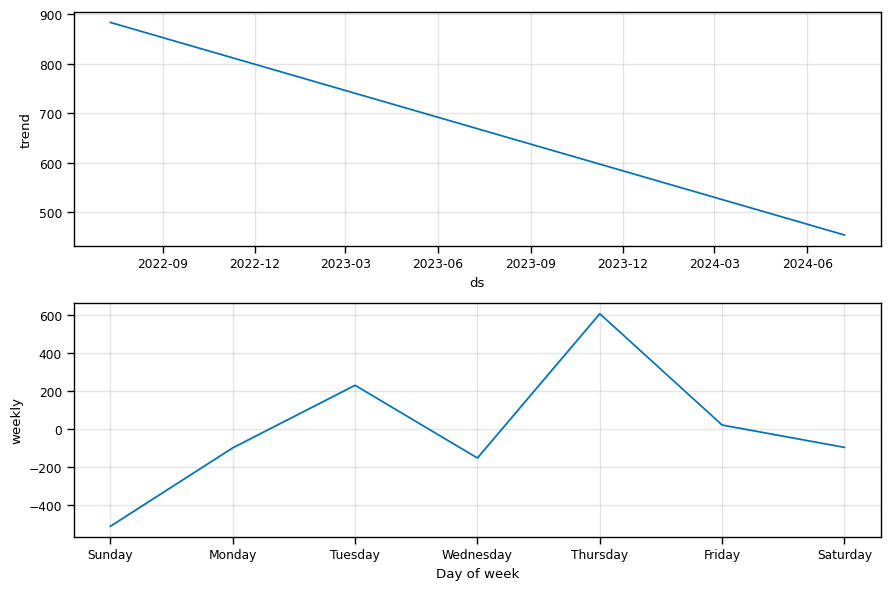

In [93]:
fig2 = model.plot_components(forecast)

#### Interactive 

In [94]:
from prophet.plot import plot_plotly, plot_components_plotly

plot_plotly(model, forecast)


In [95]:
plot_components_plotly(model, forecast)

In [ ]:
!pip install -U streamlit_prophet